# Two-level system tutorial

## Import

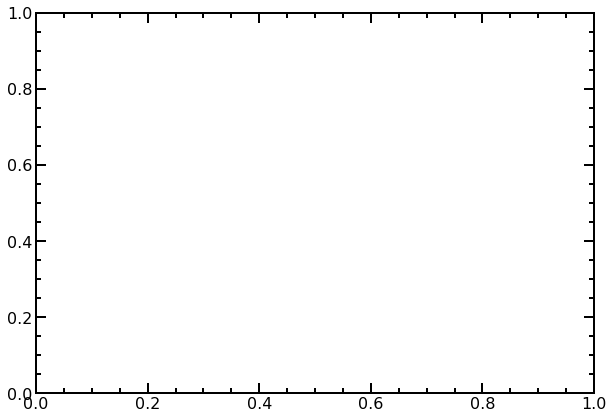

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
import plotting_settings
import scipy.linalg

## Bloch sphere

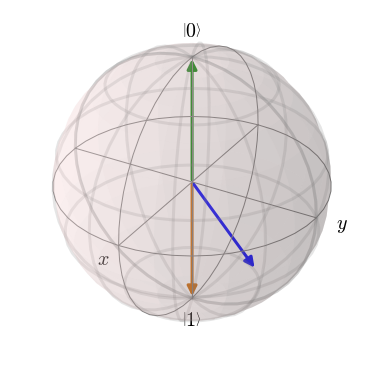

In [3]:
psi0 = basis(2,0)
psi1 = basis(2,1)
a=3
b=3j+2
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
b = Bloch()
b.add_states([psi0,psi1,psi])
b.make_sphere()

## Driving two-level system
Here, we define the two-level system via the Hamiltonian $$H=\frac{1}{2}\omega_a\sigma_Z$$ and the driving term 
$$H_d= g\cos(\omega_d t)\sigma_X$$
We can either solve the Schrodinger equation directly or use RWA to get the Hamiltonian in the rotating frame.

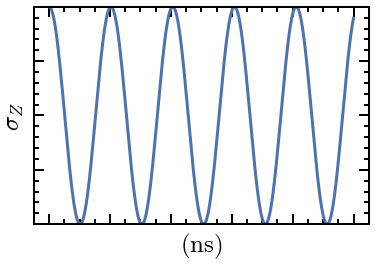

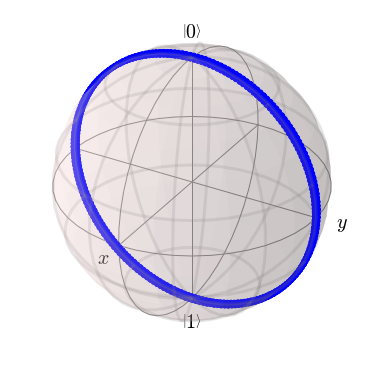

In [464]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.05 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()
tlist = np.linspace(0,100,1001)
def time_dependent_term(wd,t):
    return np.cos(2*np.pi*wd*t)
H = [H0,[H1, time_dependent_term(drive_freq,tlist)]]
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=[sigmax(), sigmay(),sigmaz()])
sx, sy, sz = output.expect[:]
plt.plot(tlist, sz)
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\langle \sigma_Z \rangle$')
b = Bloch()
b.add_points([sx, sy, sz])
b.make_sphere()

### Using RWA

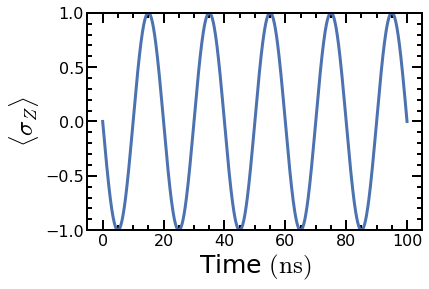

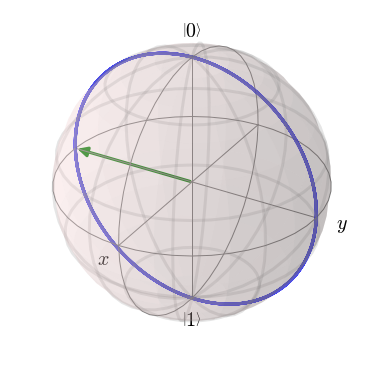

In [248]:
#Using RWA
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.05 #GHz
psi_ini = basis(2,0) - 1j*basis(2,1)
psi_ini = psi_ini/np.sqrt(2)
H = 2*np.pi*0.5*(atom_freq-drive_freq)*sigmaz() + 2*np.pi*0.5*coupl_const*sigmax()
output = mesolve(H, rho0=psi_ini,tlist = tlist, c_ops=[], e_ops=[sigmax(), sigmay(),sigmaz()])
sx, sy, sz = output.expect[:]
plt.plot(tlist,sz)
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\langle \sigma_Z \rangle$')
b = Bloch()
b.add_points([sx, sy, sz], meth='l')
b.add_states(psi_ini)
b.make_sphere()

### Pulse shape
Above we assume a constant drive. Here, we assume that the drive can be shaped by using a modulated pulse. We can redefine the drive Hamiltonian as a product of the pulse and the carrier tone.

In [201]:
#Here we define a pulse that rotates the spin by 2pi
#Also define DRAG coefficient, which we will explore later
def H_gate_pulse(t, omega_d, DRAG, DRAG_coeff, shape, sigma, T_gate):
    """ 
    H_drive_coeff_gate = xi_x(t) cos(wt) + xi_y(t) sin(wt)
    Normalization: \int xi(t') dt'= 2\pi for 0 < t' < T_gate
    If DRAG == True: xi_y(t) = alpha * d xi_x / dt,
    else: xi_y = 0
    """ 
    two_pi_t = 2 * np.pi * t
    if DRAG:
        alpha = DRAG_coeff
    else:
        alpha = 0
    if shape == 'square':
        xi_x = 1
        xi_y = 0
    elif shape == 'gauss':
        sigma = sigma * T_gate
        integral_value = (np.sqrt(2 * np.pi) * sigma
                          * scipy.special.erf(
                    T_gate / (2 * np.sqrt(2) * sigma))
                          - T_gate * np.exp(-0.5 * (0.5 * T_gate / sigma) ** 2))
        coeff = 2 * np.pi / integral_value
        xi_x = coeff * (np.exp(- 0.5 * ((t - T_gate / 2) / sigma) ** 2)
                        - np.exp(-0.5 * (0.5 * T_gate / sigma) ** 2))
        xi_y = (alpha * coeff * (- (t - T_gate / 2) / sigma ** 2)
                * np.exp(- 0.5 * ((t - T_gate / 2) / sigma) ** 2))
    return (xi_x * np.cos(two_pi_t*omega_d)
            + xi_y * np.sin(two_pi_t*omega_d))

Text(0, 0.5, '$\\mathrm{\\langle \\sigma_Z \\rangle}$')

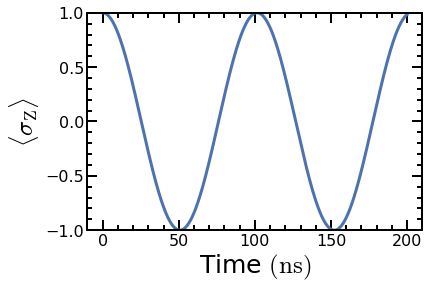

In [257]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.01 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()

tlist = np.linspace(0,200,2001) #ns
H = [H0,[H1, H_gate_pulse(tlist, omega_d = drive_freq, sigma = 0.25, T_gate = 1, DRAG = False, DRAG_coeff = 0, shape = "square")]]
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=sigmaz())
sz = output.expect[0]
plt.plot(tlist, sz)
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\mathrm{\langle \sigma_Z \rangle}$')

We can check the state fidelity during the drive

Text(0, 0.5, '$\\mathcal{F}(|0\\rangle)$')

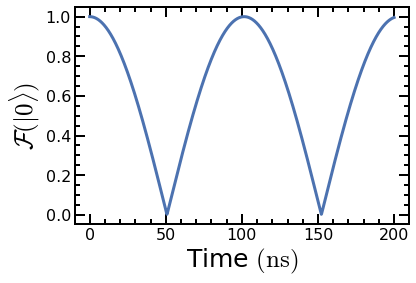

In [51]:
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=[])
states = output.states
fidelity_list = np.zeros(len(tlist))
for idx in range(len(tlist)):
    fidelity_list[idx] = fidelity(states[idx], basis(2,0))
plt.plot(tlist, fidelity_list)
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\mathcal{F}(|0\rangle)$')

### Using the propagator

In [263]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.01 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()
tlist = np.linspace(0,200,2001) #ns
H = [H0,[H1, np.cos(2*np.pi*drive_freq*tlist)]]
U = propagator(H, t=tlist)

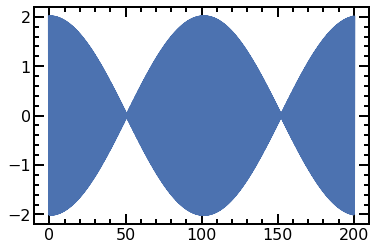

In [264]:
trace_array = np.zeros_like(tlist)
for idx in range(len(tlist)):
    trace_array[idx] = (U[idx].tr())
plt.plot(tlist, np.real(trace_array))

### Three level system

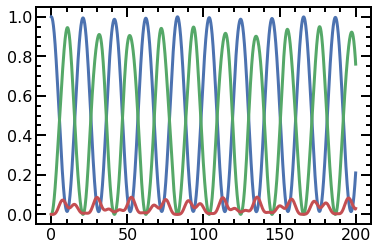

In [266]:
#Now look at three level system
wa = 5
anharmonicity = -0.1
w0 = 0
w1 = wa
w2 = 2*wa+anharmonicity
p0 = basis(3,0)*basis(3,0).dag()
p1 = basis(3,1)*basis(3,1).dag()
p2 = basis(3,2)*basis(3,2).dag()
H0 = w0*p0 + w1*p1 + w2*p2
coupl_matrix = (np.diag(np.ones(2), 1) + np.diag(np.ones(2), -1))
wd = wa
coupl_const = 0.05
H1 = coupl_const*Qobj(coupl_matrix)
H = [2*np.pi*H0,[2*np.pi*H1, H_gate_pulse(tlist, omega_d = drive_freq, sigma = 0.25, T_gate = 20, DRAG = False, DRAG_coeff = 0, shape = "square")]]
output = mesolve(H, rho0=basis(3,0), tlist=tlist, c_ops=[], e_ops=[p0,p1,p2])
pop0, pop1, pop2 = output.expect[:]
plt.plot(tlist, pop0)
plt.plot(tlist, pop1)
plt.plot(tlist, pop2)

# Coupled system

Text(0, 0.5, 'Transition freq')

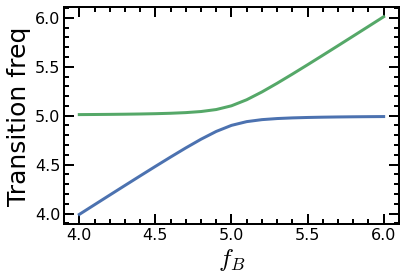

In [94]:
sza = tensor(sigmaz(),qeye(2))
sxa = tensor(sigmax(),qeye(2))
szb = tensor(qeye(2), sigmaz())
sxb = tensor(qeye(2), sigmax())
def coupled_tls_hamiltonian(wa,wb,g):
    return wa*sza/2 + wb*szb/2 + g*sxa*sxb

freq_a = 5
freq_b = np.linspace(4,6,21)
coupling = 0.1
energies = np.zeros((len(freq_b), 4))
for idx, wb in enumerate(freq_b):
    energies[idx,:] = coupled_tls_hamiltonian(freq_a,wb,coupling).eigenenergies()
for idy in range(1,3):
    plt.plot(freq_b, energies[:,idy]-energies[:,0])
plt.xlabel(r'$f_B$')
plt.ylabel('Transition freq')

Text(0, 0.5, '$\\delta f_{00-10}$')

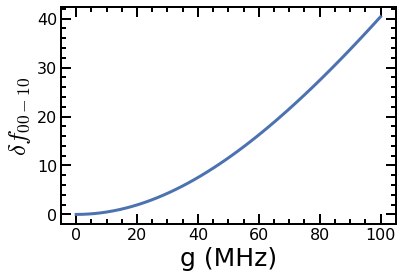

In [148]:
freq_a = 5
freq_b = 4.8
coupling = np.linspace(0,0.1)
energies = np.zeros((len(coupling), 4))
for idx, g in enumerate(coupling):
    energies[idx,:] = coupled_tls_hamiltonian(freq_a,freq_b,g).eigenenergies()
trans_freq = energies[:,1]   - energies[:,0]
trans_freq = abs(trans_freq - np.max(trans_freq))
plt.plot(coupling*1e3, trans_freq*1e3)
plt.xlabel('g (MHz)')
plt.ylabel(r'$\delta f_{00-10}$')

In [430]:
sza = tensor(sigmaz(),qeye(2))
sxa = tensor(sigmax(),qeye(2))
szb = tensor(qeye(2), sigmaz())
sxb = tensor(qeye(2), sigmax())
def coupled_tls_hamiltonian(wa,wb,g):
    return wa*sza/2 + wb*szb/2 + g*sxa*sxb
def time_dependent_term(wd, t):
    return np.cos(2*np.pi*wd*t)

tlist = np.linspace(0,50,501) 
freq_a = 5 
freq_b = 4.8 
g = 0.01 
coupl_const = 0.02 
H_coupled = coupled_tls_hamiltonian(freq_a,freq_b,g)
energies = H_coupled.eigenenergies()
print (energies - energies[0])
# A: 00-10, 01-11, B: 00-01, 10-11 
H0 = H_coupled
drive_freq = energies[1] - energies[0] #qubit b
H1 = coupl_const*sxa
H = [2*np.pi*H0,[2*np.pi*H1, time_dependent_term(drive_freq, tlist)]]
output = mesolve(H, rho0=tensor(basis(2,0), basis(2,0)), tlist=tlist, c_ops=[], e_ops=[])

[0.         4.79951145 5.00050896 9.80002041]


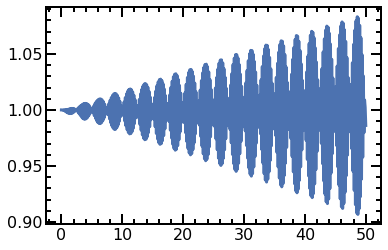

In [431]:
pop_a = np.zeros_like(tlist, dtype = complex)
pop_b = np.zeros_like(tlist, dtype = complex)
for t_idx, t in enumerate(tlist):
    pop_a[t_idx] = output.states[t_idx][0][0,0]+output.states[t_idx][1][0,0]
    pop_b[t_idx] = output.states[t_idx][0][0,0]+output.states[t_idx][2][0,0]
plt.plot(tlist, abs(pop_a))
# plt.plot(tlist, expect(szb, output.states))

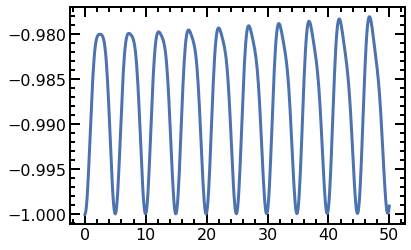

In [412]:
plt.plot(tlist, expect(sza, output.states))

In [452]:
sza = tensor(sigmaz(),qeye(2))
sxa = tensor(sigmax(),qeye(2))
szb = tensor(qeye(2), sigmaz())
sxb = tensor(qeye(2), sigmax())
def coupled_tls_hamiltonian(wa,wb,g):
    return wa*sza/2 + wb*szb/2 + g*sxa*sxb
def time_dependent_term (wd,t):
    return np.cos(2*np.pi*wd*t)
H0 = coupled_tls_hamiltonian(freq_a,freq_b,g)
H1 = coupl_const*sxa
energies, eigenstates = H0.eigenstates()
mapping = np.zeros((2,2))
for i in [0,1]:
    for j in [0,1]:
        ket = tensor(basis(2,i), basis(2,j))
        for k,state in enumerate(eigenstates):
            if abs(state.dag()*ket)>0.95:
                mapping[i,j]=k
# print('mapping table : {0}'.format(mapping))
tlist = np.linspace(0,500,1001) *1e-9
freq_a = 5 *1e9
freq_b = 4.8 * 1e9
g = 0.005 *1e9
coupl_const = 0.05 *1e9
drive_freq = energies[1] - energies[0]
H = [2*np.pi*H0,[2*np.pi*H1, 'np.cos(2*np.pi*drive_freq*t)']]
e_ops = [ket2dm(eigenstates[int(mapping[1,1])]),ket2dm(eigenstates[int(mapping[1,0])])]
output = mesolve(H, rho0=tensor(basis(2,0), basis(2,0)), tlist=tlist, c_ops=[], e_ops=e_ops)
plt.plot(tlist, output.expect[0], tlist, output.expect[1])


Error compiling Cython file:
------------------------------------------------------------
...

cdef class CompiledStrCoeff(StrCoeff):

    cdef void _call_core(self, double t, complex * coeff):

        coeff[0] = np.cos(2*np.pi*drive_freq*t)
                                 ^
------------------------------------------------------------

cqobjevo_compiled_coeff_280845223190.pyx:31:34: undeclared name not builtin: drive_freq

Error compiling Cython file:
------------------------------------------------------------
...

cdef class CompiledStrCoeff(StrCoeff):

    cdef void _call_core(self, double t, complex * coeff):

        coeff[0] = np.cos(2*np.pi*drive_freq*t)
                                 ^
------------------------------------------------------------

cqobjevo_compiled_coeff_280845223191.pyx:31:34: undeclared name not builtin: drive_freq

Error compiling Cython file:
------------------------------------------------------------
...

cdef class CompiledStrCoeff(StrCoeff):

    cd

Exception: Could not convert string to importable function, tmpfile:cqobjevo_compiled_coeff_280845223192.pyx

Exception: Could not convert string to importable function, tmpfile:cqobjevo_compiled_coeff_831845218162.pyx